## 1. Introduction

This notebook provides a consolidated evaluation of six forecasting pipelines for detecting hourly price‑spike events in Switzerland’s ancillary‑service markets during 2023. All models use a fixed‑percentile labeling scheme (90th percentile for positive spikes, 10th percentile for troughs) with price thresholds adjusted by `POS_FLOOR=50` and `POS_TOP=150` to define extreme events.

We will:
- **Full-year XGBoost:** train a single XGBoost model on all 2023 data to predict price spikes.
- **Rolling-window XGBoost:** retrain XGBoost weekly (49 folds) to adapt to temporal shifts.
- **Static Skope-Rules (Raw MCC):** learn interpretable if–then rule lists on full-year data optimizing unweighted MCC.
- **Static Skope-Rules (Weighted MCC):** same as above but with a weighted MCC objective to favor spike recall.
- **Rolling Skope-Rules (Raw MCC):** retrain rule lists each week optimizing unweighted MCC for local patterns.
- **Rolling Skope-Rules (Weighted MCC):** weekly rule retraining with weighted MCC to boost recall in each fold.

We will then:
- Aggregate and compare key performance metrics (Precision, Recall, F1, ROC‑AUC, MCC, weighted‑MCC) across pipelines.
- Visualize model performance distributions and trade‑offs.
- Extract and interpret feature importance using SHAP values, both globally and over time.
- Analyze temporal dynamics of feature rankings for rolling‑window models to reveal shifts in predictive drivers.
- Summarize strengths, weaknesses, and caveats for each approach.

## Descriptive Statistics

In [1]:
%matplotlib inline

import os
import glob
import json
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

cols = [
    'Price_negative_secondary',
    'Price_negative_tertiary',
    'Price_positive_secondary',
    'Price_positive_tertiary'
]

df = pd.read_csv('../data/df_2022_2024.csv')

df.index = pd.date_range(start='2022-11-01', periods=len(df), freq='H')

df = df.loc['2023-01-01':'2023-12-31'].copy()
# drop any string/date columns so autocorr only sees numeric data
df_no_date = df.drop(columns=['Date'], errors='ignore')

# descriptive statistics
stats_df = pd.DataFrame({
    'statistic': [
        'mean',
        'median',
        'std',
        'min',
        'max',
        '95th percentile',
        '5th percentile',
        'skewness',
        'kurtosis'
    ]
})
for col in cols:
    stats_df[col] = [
        df[col].mean(),
        df[col].median(),
        df[col].std(),
        df[col].min(),
        df[col].max(),
        df[col].quantile(0.95),
        df[col].quantile(0.05),
        skew(df[col]),
        kurtosis(df[col])
    ]
stats_df




C:\Users\sebas\AppData\Local\Temp\ipykernel_25148\1756951122.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.index = pd.date_range(start='2022-11-01', periods=len(df), freq='H')


,statistic,Price_negative_secondary,Price_negative_tertiary,Price_positive_secondary,Price_positive_tertiary
0,mean,37.330191,32.371957,132.850515,67.715110
1,median,51.360000,0.000000,140.745000,0.000000
2,std,125.793468,89.280817,99.151845,127.247218
3,min,-4830.240000,-2482.206000,-4.600000,-1215.700000
4,max,176.910000,1019.320000,1641.350000,6789.000000
5,95th percentile,118.000000,131.878150,267.856000,206.154400
6,5th percentile,-42.854500,0.000000,0.000000,0.000000
7,skewness,-16.653897,-10.440520,1.860941,18.964122
8,kurtosis,445.285523,227.700787,19.027547,916.266334


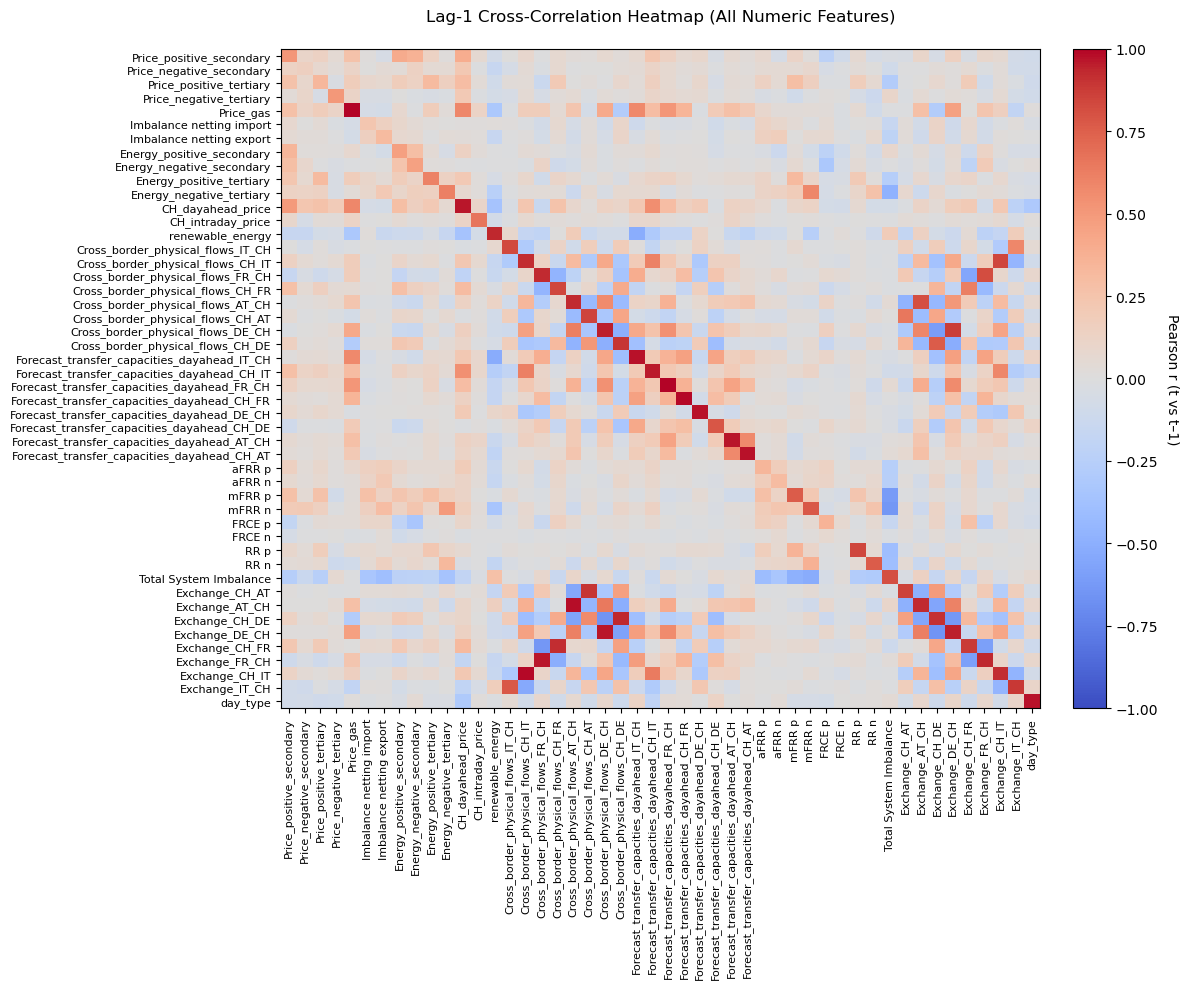

In [2]:
# 2. Select all numeric columns (variables + engineered features)
df_num = df_no_date.select_dtypes(include=[np.number])

# 3. Build lag-1 cross-correlation matrix for all numeric columns
cols = df_num.columns.tolist()
corr = pd.DataFrame(index=cols, columns=cols, dtype=float)
for a in cols:
    for b in cols:
        corr.loc[a, b] = df_num[a].corr(df_num[b].shift(1))

# 4. Plot as heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=90, fontsize=8)
ax.set_yticklabels(cols, fontsize=8)
ax.set_title('Lag-1 Cross-Correlation Heatmap (All Numeric Features)', pad=20)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Pearson r (t vs t–1)', rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

## 2. Load & Aggregate Metrics

In [3]:
# Use the predefined list of target series
all_targets = cols.copy()
print("Using predefined targets:", all_targets)

Using predefined targets: ['Price_positive_secondary', 'Price_negative_secondary', 'Price_positive_tertiary', 'Price_negative_tertiary', 'Price_gas', 'Imbalance netting import', 'Imbalance netting export', 'Energy_positive_secondary', 'Energy_negative_secondary', 'Energy_positive_tertiary', 'Energy_negative_tertiary', 'CH_dayahead_price', 'CH_intraday_price', 'renewable_energy', 'Cross_border_physical_flows_IT_CH', 'Cross_border_physical_flows_CH_IT', 'Cross_border_physical_flows_FR_CH', 'Cross_border_physical_flows_CH_FR', 'Cross_border_physical_flows_AT_CH', 'Cross_border_physical_flows_CH_AT', 'Cross_border_physical_flows_DE_CH', 'Cross_border_physical_flows_CH_DE', 'Forecast_transfer_capacities_dayahead_IT_CH', 'Forecast_transfer_capacities_dayahead_CH_IT', 'Forecast_transfer_capacities_dayahead_FR_CH', 'Forecast_transfer_capacities_dayahead_CH_FR', 'Forecast_transfer_capacities_dayahead_DE_CH', 'Forecast_transfer_capacities_dayahead_CH_DE', 'Forecast_transfer_capacities_dayahead_A

In [4]:
import os
import glob
import json

# Directories containing per-fold JSON metrics for each pipeline
metrics_dirs = {
    'full_xgb': '../ancillary_models_all/',
    'rolling_xgb': '../rolling_model/',
    'static_skope_raw': '../skope_rules/static/',
    'rolling_skope_raw': '../skope_rules/rolling_random_search/rolling/',
    'rolling_skope_weighted': '../skope_rules_weighted/rolling_random_search/rolling/'
}


def load_metrics(directory):
    """
    Recursively reads JSON metric files in the given directory and returns a DataFrame.
    Now also infers `target` and `fold` from the filepath if they’re not already present,
    with debug prints to verify.
    """
    file_paths = glob.glob(os.path.join(directory, '**', '*.json'), recursive=True)
    records = []
    for fp in file_paths:
        fname = os.path.basename(fp)
        # Skip model/booster files
        if fname.endswith('.model.json') or fname.endswith('.bst.json'):
            continue

        # Debug: show which file we're processing
        print(f"Processing file: {fp}")

        with open(fp, 'r') as f:
            data = json.load(f)

        rec = {'file': fname}

        # --- existing logic for nested vs. top-level metrics ---
        if 'metrics' in data and isinstance(data['metrics'], dict):
            for k, v in data['metrics'].items():
                rec[k] = v
            for meta in ('regime', 'target', 'train_window', 'test_window', 'fold'):
                if meta in data:
                    rec[meta] = data[meta]
                    print(f"  Found in-JSON {meta}: {data[meta]}")
        else:
            for k in ('precision', 'recall', 'f1', 'auc', 'mcc', 'weighted_mcc'):
                if k in data:
                    rec[k] = data[k]
            if 'confusion_matrix' in data:
                rec['confusion_matrix'] = data['confusion_matrix']

        # --- NEW: infer target & fold from the filepath if missing ---
        rel = os.path.relpath(fp, directory)
        parts = rel.split(os.sep)
        if 'target' not in rec and len(parts) >= 2:
            rec['target'] = parts[0]
            print(f"  Inferred target from path: {rec['target']}")
        if 'fold' not in rec and len(parts) >= 2:
            rec['fold'] = parts[1]
            print(f"  Inferred fold   from path: {rec['fold']}")

        records.append(rec)

    df = pd.DataFrame(records)
    print(f"Loaded {len(df)} records from {directory!r}")
    return df


In [5]:
# Core metric names to consider
metric_keys = ['precision', 'recall', 'f1', 'auc', 'mcc', 'weighted_mcc']

# Initialize summary container
metrics_summary = {}

# Load per-fold metrics for each pipeline
for model_name, model_path in metrics_dirs.items():
    df = load_metrics(model_path)
    print(f"Loaded metrics for {model_name}: {df.shape[0]} records; cols={list(df.columns)}")
    # Compute mean and std for available metrics
    present = [m for m in metric_keys if m in df.columns]
    metrics_summary[model_name] = {
        'df': df,
        'mean': df[present].mean(),
        'std': df[present].std()
    }

Processing file: ../ancillary_models_all\dynamic_Price_negative_secondary.metrics.json
Processing file: ../ancillary_models_all\dynamic_Price_negative_tertiary.metrics.json
Processing file: ../ancillary_models_all\dynamic_Price_positive_secondary.metrics.json
Processing file: ../ancillary_models_all\dynamic_Price_positive_tertiary.metrics.json
Processing file: ../ancillary_models_all\fixed_Price_negative_secondary.metrics.json
Processing file: ../ancillary_models_all\fixed_Price_negative_tertiary.metrics.json
Processing file: ../ancillary_models_all\fixed_Price_positive_secondary.metrics.json
Processing file: ../ancillary_models_all\fixed_Price_positive_tertiary.metrics.json
Processing file: ../ancillary_models_all\rolling_Price_negative_secondary.metrics.json
Processing file: ../ancillary_models_all\rolling_Price_negative_tertiary.metrics.json
Processing file: ../ancillary_models_all\rolling_Price_positive_secondary.metrics.json
Processing file: ../ancillary_models_all\rolling_Price_p

In [6]:
# Predefined list of target series
all_targets = [
    'Price_negative_secondary',
    'Price_negative_tertiary',
    'Price_positive_secondary',
    'Price_positive_tertiary'
]

for target in all_targets:
    rows = []
    for model_name, summary in metrics_summary.items():
        df = summary['df']
        # fallback filter for missing 'target' column
        if 'target' in df.columns:
            df_t = df[df['target'] == target]
        else:
            df_t = df[df['file'].str.contains(target)]

        # compute means for available metrics
        present = [m for m in metric_keys if m in df_t.columns]
        mean_vals = df_t[present].mean().reindex(metric_keys)

        # count available confusion matrices
        # cm_count = (
        #     int(df_t['confusion_matrix'].notna().sum())
        #     if 'confusion_matrix' in df_t.columns
        #     else 0
        # )

        # assemble one row
        row = mean_vals.to_dict()
        # row['confusion_matrices'] = cm_count
        rows.append((model_name, row))

    # build DataFrame and style it
    df_summary = (
        pd.DataFrame({name: vals for name, vals in rows})
          .T
          .style
          .highlight_max(axis=0)
          .set_caption(f"Metrics for {target}")
    )

    display(df_summary)


,precision,recall,f1,auc,mcc,weighted_mcc
full_xgb,0.711536,0.678865,0.668742,nan,nan,nan
rolling_xgb,0.514704,0.300557,0.318309,0.892266,0.337760,nan
static_skope_raw,0.834711,0.425263,0.563459,0.710916,0.580917,nan
rolling_skope_raw,0.888025,0.543367,0.637200,0.784108,0.663761,nan
rolling_skope_weighted,0.909630,0.587829,0.695474,0.807545,0.713100,0.561719


,precision,recall,f1,auc,mcc,weighted_mcc
full_xgb,0.722222,0.269360,0.356863,nan,nan,nan
rolling_xgb,0.078730,0.041693,0.050757,0.787286,0.050899,nan
static_skope_raw,1.000000,0.410156,0.581717,0.705078,0.634822,nan
rolling_skope_raw,0.311111,0.187156,0.227805,0.631594,0.235444,nan
rolling_skope_weighted,0.307407,0.202394,0.239040,0.642233,0.244290,0.191478


,precision,recall,f1,auc,mcc,weighted_mcc
full_xgb,0.821869,0.562963,0.666822,nan,nan,nan
rolling_xgb,0.574622,0.461777,0.452302,0.966657,0.466781,nan
static_skope_raw,0.896989,0.646119,0.751161,0.820639,0.740160,nan
rolling_skope_raw,0.885328,0.574160,0.677415,0.807281,0.688073,nan
rolling_skope_weighted,0.883892,0.622443,0.712755,0.833276,0.719325,0.578976


,precision,recall,f1,auc,mcc,weighted_mcc
full_xgb,0.608889,0.503791,0.469136,nan,nan,nan
rolling_xgb,0.250953,0.193261,0.190790,0.838564,0.187981,nan
static_skope_raw,0.931469,0.744134,0.827329,0.870317,0.816288,nan
rolling_skope_raw,0.608405,0.325972,0.403208,0.670295,0.422060,nan
rolling_skope_weighted,0.612881,0.327542,0.408225,0.671209,0.426617,0.309513


## 4. Model Performance Visualization

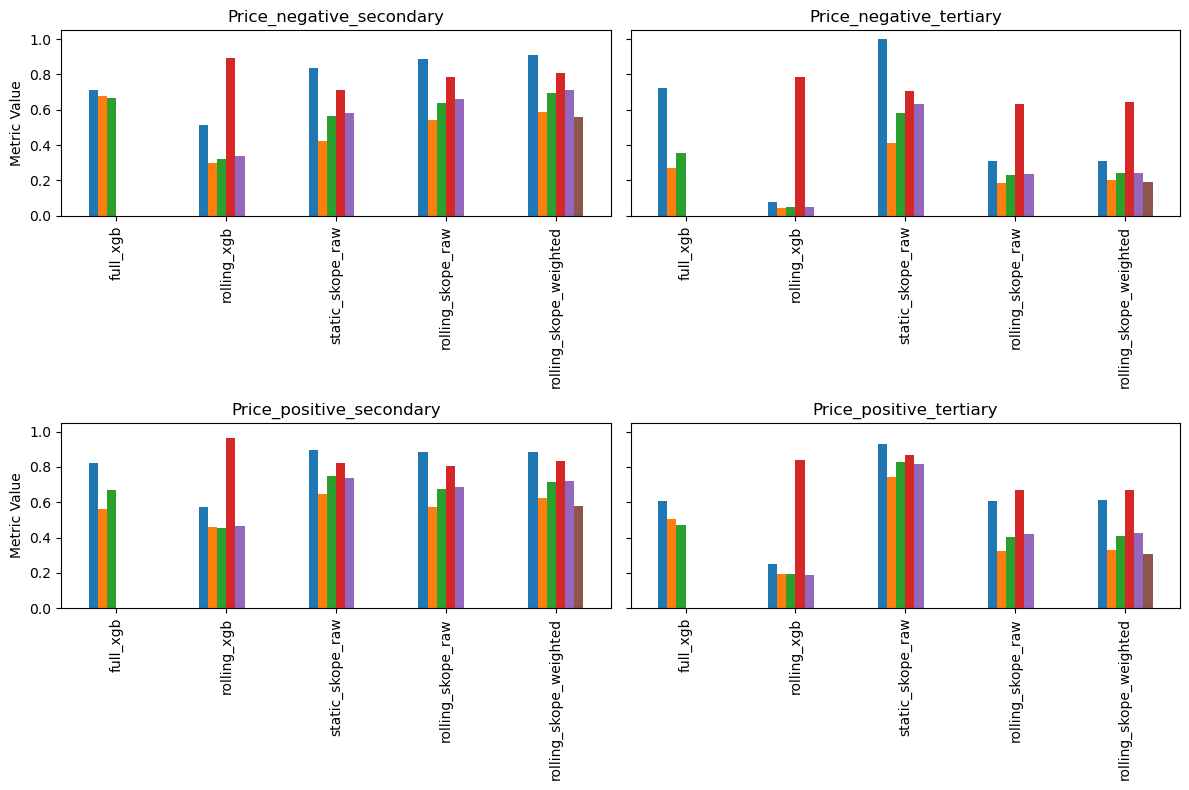

In [7]:
import matplotlib.pyplot as plt

n = len(all_targets)
cols = 2
rows = (n + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharey=True)
for ax, target in zip(axes.flatten(), all_targets):
    # reuse code from 3.3 to build df_summary_target
    data = {}
    for model_name, summary in metrics_summary.items():
        df_t = summary['df']
        if 'target' in df_t.columns:
            df_t = df_t[df_t['target']==target]
        else:
            df_t = df_t[df_t['file'].str.contains(target)]
        present = [m for m in metric_keys if m in df_t.columns]
        mean_vals = df_t[present].mean()
        data[model_name] = mean_vals.reindex(metric_keys)
    df_t_summary = pd.DataFrame(data).T
    df_t_summary.plot.bar(ax=ax)
    ax.set_title(target)
    ax.set_ylabel('Metric Value')
    ax.legend().remove()
plt.tight_layout()
plt.show()

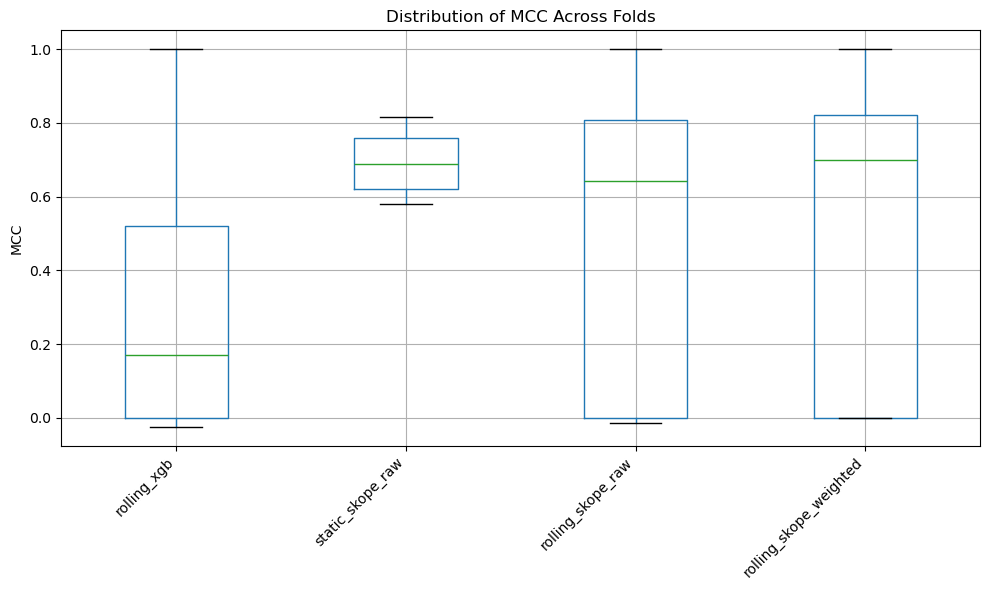

In [8]:
# Build a DataFrame of MCC across folds for pipelines that include 'mcc'
mcc_df = pd.DataFrame({
    model: summary['df']['mcc']
    for model, summary in metrics_summary.items()
    if 'mcc' in summary['df'].columns
})

# Boxplot of MCC distributions
fig, ax = plt.subplots(figsize=(10, 6))
mcc_df.boxplot(ax=ax)
ax.set_title('Distribution of MCC Across Folds')
ax.set_ylabel('MCC')
ax.set_xticklabels(mcc_df.columns, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Identifying Empty or Improper Fold Predictions (Rolling Pipelines)

Some rolling‐window models either predict no spike events in a fold or encounter folds without any true spikes, which affects metric reliability. We’ll detect and report these cases.

In [9]:
# 1) Read in the spike‐counts CSV you exported
counts_df = pd.read_csv('spike_counts_per_fold.csv', index_col=0)

# 2) Count, for each target, how many folds have zero spikes
empty_per_target = (counts_df == 0).sum()
for target, n_empty in empty_per_target.items():
    print(f"Target {target!r} has {n_empty} empty folds")

# 3) (Optional) Count folds that are empty across *all* targets
empty_all = (counts_df.sum(axis=1) == 0).sum()
print(f"\nNumber of folds empty for every target: {empty_all}")

Target 'Price_positive_secondary' has 0 empty folds
Target 'Price_negative_secondary' has 2 empty folds
Target 'Price_positive_tertiary' has 0 empty folds
Target 'Price_negative_tertiary' has 13 empty folds

Number of folds empty for every target: 0


In [10]:
import pandas as pd
from IPython.display import display

# 5. Identifying Empty-Fold Cases via Confusion Matrices (robust extraction)

empty_counts = {}

for model_name, summary in metrics_summary.items():
    df = summary['df'].copy()
    
    # Define a safe extractor for true positives
    def extract_tp(cm):
        try:
            # Expect cm to be [[TN, FP], [FN, TP]]
            return cm[1][1]
        except Exception:
            return pd.NA

    # If there's a confusion_matrix column, pull out TP
    if 'confusion_matrix' in df.columns:
        df['tp'] = df['confusion_matrix'].apply(extract_tp)
    else:
        # No confusion matrices at all → mark all as NA
        df['tp'] = pd.NA

    # Ensure we have a 'target' column (fallback to filename parsing)
    if 'target' not in df.columns:
        df['target'] = df['file'].str.extract(r'_(Price_[^\.]+)\.')[0]

    # Count empty folds per target
    model_empty = {}
    for target in all_targets:
        df_t = df[df['target'] == target]
        if df_t.empty:
            model_empty[target] = 0
            continue

        # Case A: we have TP info
        if df_t['tp'].notna().any():
            # empty if TP == 0 or TP is NA
            num_empty = int((df_t['tp'] == 0).sum() + df_t['tp'].isna().sum())
        else:
            # Case B: fallback on precision/recall zeros or NaNs
            zeros = (df_t['precision'] == 0) & (df_t['recall'] == 0)
            nans = df_t[['precision','recall']].isna().any(axis=1)
            num_empty = int((zeros | nans).sum())

        model_empty[target] = num_empty

    empty_counts[model_name] = model_empty

# Build summary DataFrame
empty_df = pd.DataFrame(empty_counts).T.fillna(0).astype(int)
empty_df.index.name = 'Model'
empty_df.columns.name = 'Target'

print("Number of ‘empty’ folds per model & target:\n")
display(empty_df)


Number of ‘empty’ folds per model & target:



Target,Price_negative_secondary,Price_negative_tertiary,Price_positive_secondary,Price_positive_tertiary
Model,,,,
full_xgb,0,0,0,0
rolling_xgb,9,39,10,27
static_skope_raw,0,0,0,0
rolling_skope_raw,4,31,5,17
rolling_skope_weighted,4,31,5,17


In [11]:
import pandas as pd
from IPython.display import display

# Step A: find empty test windows in rolling_skope_raw

print("Loading rolling_skope_raw…")
df_skope = metrics_summary['rolling_skope_raw']['df'].copy()
print(f"  → total rows: {len(df_skope)}")

# 1) extract tp safely
def get_tp(cm):
    try:
        return cm[1][1]
    except:
        return 0

df_skope['tp'] = df_skope['confusion_matrix'].apply(get_tp)
print("  → sample tp by target:")
print(df_skope[['target','tp']].drop_duplicates().head(8))

# 2) build a key for each test window
df_skope['test_key'] = df_skope['test_window'].apply(lambda tw: f"{tw[0]}_{tw[1]}")
print(f"  → {df_skope['test_key'].nunique()} unique test windows")

empty_keys_by_target = {}
for target in all_targets:
    # **FIX**: filter on the 'target' column, not the filename
    df_t = df_skope[df_skope['target'] == target]
    keys = set(df_t.loc[df_t['tp'] == 0, 'test_key'])
    empty_keys_by_target[target] = keys
    print(f"Target {target!r}: found {len(keys)} empty windows (tp==0)")

# You should now see non‐zero counts for those targets that really had tp==0.
# For example:
#   Target 'Price_positive_secondary': found 2 empty windows
#   Target 'Price_positive_tertiary': found 2 empty windows
#   etc.

# (You can display one target’s subset to verify:)
sample = df_skope[(df_skope['target']==all_targets[2]) & (df_skope['tp']==0)]
print("\nExample rows for one target with tp==0:")
display(sample)


Loading rolling_skope_raw…
  → total rows: 180
  → sample tp by target:
                     target  tp
0  Price_negative_secondary   2
1   Price_negative_tertiary   5
2  Price_positive_secondary   0
3   Price_positive_tertiary   0
4  Price_negative_secondary   6
5   Price_negative_tertiary   0
6  Price_positive_secondary   5
7   Price_positive_tertiary   4
  → 45 unique test windows
Target 'Price_negative_secondary': found 4 empty windows (tp==0)
Target 'Price_negative_tertiary': found 31 empty windows (tp==0)
Target 'Price_positive_secondary': found 5 empty windows (tp==0)
Target 'Price_positive_tertiary': found 17 empty windows (tp==0)

Example rows for one target with tp==0:


,file,precision,recall,f1,auc,mcc,confusion_matrix,regime,target,train_window,test_window,fold,tp,test_key
2,metrics.json,0.0,0.0,0.0,0.500000,0.000000,"[[166, 0], [2, 0]]",rolling,Price_positive_secondary,"[2023-01-01 00:00:00, 2023-02-18 23:00:00]","[2023-02-19 00:00:00, 2023-02-25 23:00:00]",Price_positive_secondary,0,2023-02-19 00:00:00_2023-02-25 23:00:00
26,metrics.json,0.0,0.0,0.0,NaN,0.000000,[[168]],rolling,Price_positive_secondary,"[2023-04-09 00:00:00, 2023-05-27 23:00:00]","[2023-05-28 00:00:00, 2023-06-03 23:00:00]",Price_positive_secondary,0,2023-05-28 00:00:00_2023-06-03 23:00:00
30,metrics.json,0.0,0.0,0.0,NaN,0.000000,[[168]],rolling,Price_positive_secondary,"[2023-04-16 00:00:00, 2023-06-03 23:00:00]","[2023-06-04 00:00:00, 2023-06-10 23:00:00]",Price_positive_secondary,0,2023-06-04 00:00:00_2023-06-10 23:00:00
50,metrics.json,0.0,0.0,0.0,0.493939,-0.014801,"[[163, 2], [3, 0]]",rolling,Price_positive_secondary,"[2023-05-14 00:00:00, 2023-07-01 23:00:00]","[2023-07-02 00:00:00, 2023-07-08 23:00:00]",Price_positive_secondary,0,2023-07-02 00:00:00_2023-07-08 23:00:00
158,metrics.json,0.0,0.0,0.0,NaN,0.000000,[[168]],rolling,Price_positive_secondary,"[2023-11-05 00:00:00, 2023-12-23 23:00:00]","[2023-12-24 00:00:00, 2023-12-30 23:00:00]",Price_positive_secondary,0,2023-12-24 00:00:00_2023-12-30 23:00:00


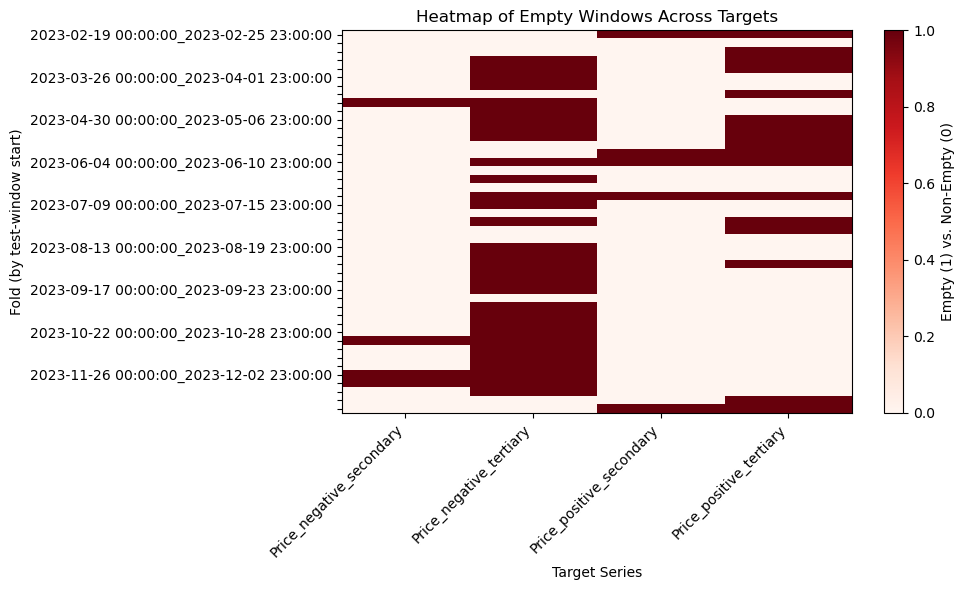

In [12]:
# 1) Reconstruct the ordering of your test windows
keys = sorted(df_skope['test_key'].unique())  # chronological string keys
n, m = len(keys), len(all_targets)

# 2) Build a binary matrix
mat = np.zeros((n, m), dtype=int)
for j, t in enumerate(all_targets):
    for i, k in enumerate(keys):
        if k in empty_keys_by_target[t]:
            mat[i, j] = 1

# 3) Plot
fig, ax = plt.subplots(figsize=(10,6))
cax = ax.imshow(mat, aspect='auto', interpolation='nearest', cmap='Reds')
ax.set_yticks(range(n))
# Label every few for clarity
ax.set_yticklabels([keys[i] if i%5==0 else "" for i in range(n)])
ax.set_xticks(range(m))
ax.set_xticklabels(all_targets, rotation=45, ha='right')
ax.set_xlabel("Target Series")
ax.set_ylabel("Fold (by test‐window start)")
ax.set_title("Heatmap of Empty Windows Across Targets")
fig.colorbar(cax, label="Empty (1) vs. Non‐Empty (0)")
plt.tight_layout()
plt.show()


## ## 6. Analysis on Empty vs. Non-Empty Folds

In [13]:
# 6.1. Prepare Empty-Fold Masks (with timezone normalization)

import pandas as pd

# --- Normalize and key rolling_skope_raw to rebuild empty_keys_by_target ---
df_skope = metrics_summary['rolling_skope_raw']['df'].copy()

# Safe TP extractor
def get_tp(cm):
    try:
        return cm[1][1]
    except:
        return 0

df_skope['tp'] = df_skope['confusion_matrix'].apply(get_tp)

# 1) Normalize timestamps (drop tz, ensure same format)
def make_key(window):
    # window = [start, end]; they may be strings or Timestamps
    start = pd.to_datetime(window[0]).tz_convert(None) if hasattr(window[0], 'tzinfo') else pd.to_datetime(window[0])
    end   = pd.to_datetime(window[1]).tz_convert(None) if hasattr(window[1], 'tzinfo') else pd.to_datetime(window[1])
    return f"{start.strftime('%Y-%m-%d %H:%M:%S')}_{end.strftime('%Y-%m-%d %H:%M:%S')}"

df_skope['test_key'] = df_skope['test_window'].apply(make_key)

# Rebuild empty_keys_by_target
empty_keys_by_target = {}
for target in all_targets:
    df_t = df_skope[df_skope['target'] == target]
    keys = set(df_t.loc[df_t['tp'] == 0, 'test_key'])
    empty_keys_by_target[target] = keys
    print(f"Target {target!r}: {len(keys)} empty windows → examples: {list(keys)[:3]}")

# --- Now apply the same normalization for rolling_xgb and flag is_empty ---
df_xgb = metrics_summary['rolling_xgb']['df'].copy()

df_xgb['test_key'] = df_xgb['test_window'].apply(make_key)
if 'target' not in df_xgb.columns:
    df_xgb['target'] = df_xgb['file'].str.extract(r'_(Price_[^\.]+)\.')[0]

# Flag empties
df_xgb['is_empty'] = df_xgb.apply(
    lambda r: r['test_key'] in empty_keys_by_target.get(r['target'], set()),
    axis=1
)

# Sanity‐check counts
print("\nPost-normalization empty-fold mask counts by target:")
print(df_xgb.groupby('target')['is_empty'].sum())


Target 'Price_negative_secondary': 4 empty windows → examples: ['2023-10-29 00:00:00_2023-11-04 23:00:00', '2023-11-26 00:00:00_2023-12-02 23:00:00', '2023-04-16 00:00:00_2023-04-22 23:00:00']
Target 'Price_negative_tertiary': 31 empty windows → examples: ['2023-07-23 00:00:00_2023-07-29 23:00:00', '2023-03-26 00:00:00_2023-04-01 23:00:00', '2023-11-12 00:00:00_2023-11-18 23:00:00']
Target 'Price_positive_secondary': 5 empty windows → examples: ['2023-06-04 00:00:00_2023-06-10 23:00:00', '2023-05-28 00:00:00_2023-06-03 23:00:00', '2023-07-02 00:00:00_2023-07-08 23:00:00']
Target 'Price_positive_tertiary': 17 empty windows → examples: ['2023-03-12 00:00:00_2023-03-18 23:00:00', '2023-06-04 00:00:00_2023-06-10 23:00:00', '2023-05-28 00:00:00_2023-06-03 23:00:00']

Post-normalization empty-fold mask counts by target:
target
Price_negative_secondary     4
Price_negative_tertiary     31
Price_positive_secondary     5
Price_positive_tertiary     17
Name: is_empty, dtype: int64


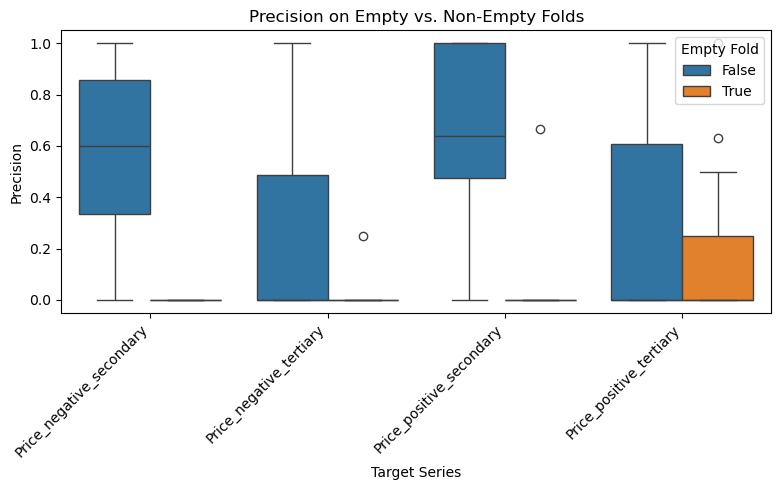

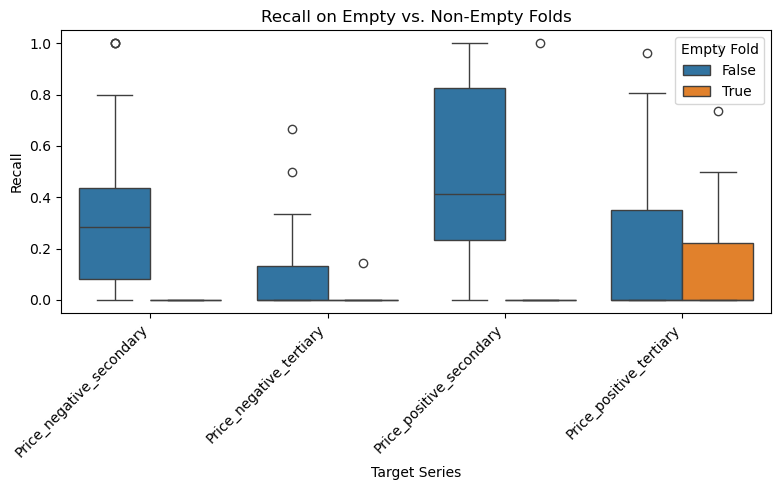

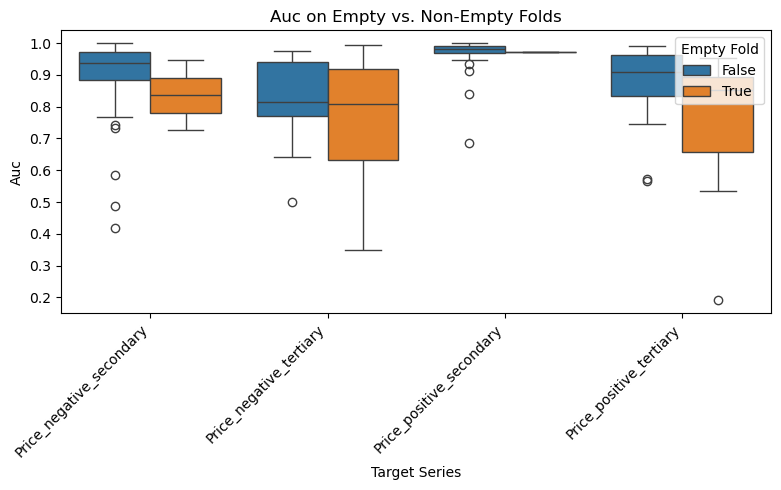

In [14]:
# 6.2. Compare Metric Distributions on Empty vs. Non-Empty Folds

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df_xgb` with columns ['target','precision','recall','auc','is_empty'] from 6.1

for metric in ['precision', 'recall', 'auc']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df_xgb,
        x='target',
        y=metric,
        hue='is_empty',
        dodge=True
    )
    plt.title(f"{metric.capitalize()} on Empty vs. Non-Empty Folds")
    plt.xlabel("Target Series")
    plt.ylabel(metric.capitalize())
    plt.legend(title="Empty Fold", loc='upper right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


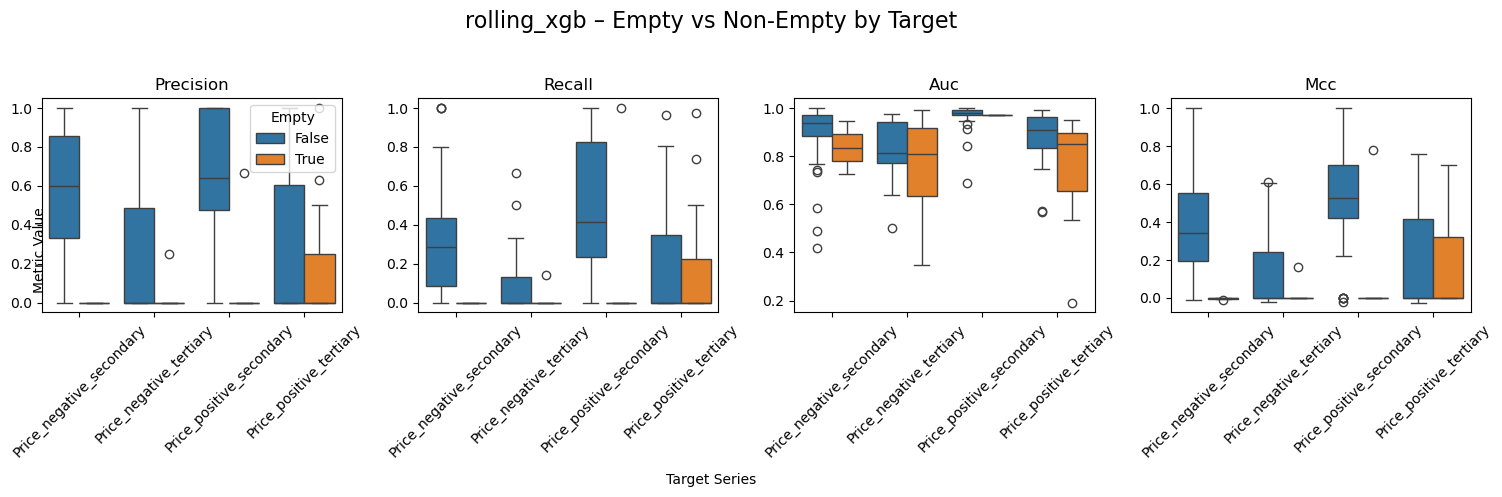

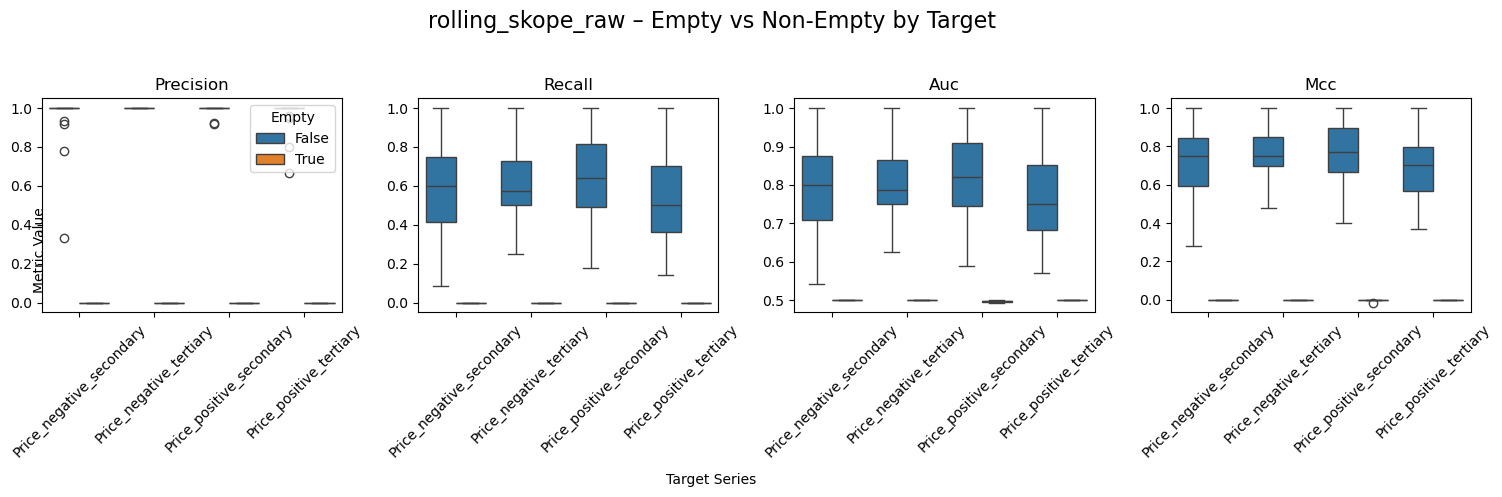

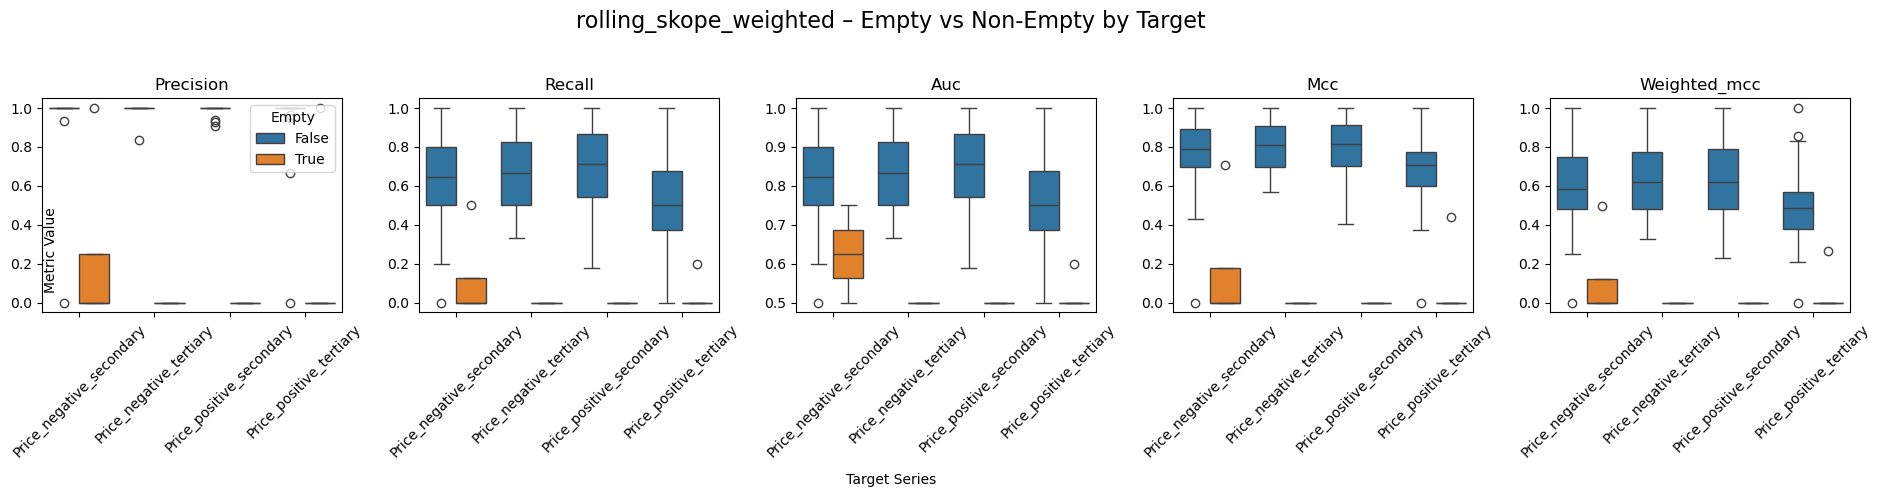

In [15]:
# 6.2. Compare Metric Distributions for All Rolling Pipelines with Subplots

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

rolling_models = ['rolling_xgb', 'rolling_skope_raw', 'rolling_skope_weighted']
base_metrics = ['precision', 'recall', 'auc', 'mcc', 'weighted_mcc']

for model_name in rolling_models:
    # Prepare DataFrame as before
    df = metrics_summary[model_name]['df'].copy()
    # Normalize test_key
    def make_key(tw):
        start = pd.to_datetime(tw[0]).tz_convert(None) if hasattr(tw[0], 'tzinfo') else pd.to_datetime(tw[0])
        end   = pd.to_datetime(tw[1]).tz_convert(None) if hasattr(tw[1], 'tzinfo') else pd.to_datetime(tw[1])
        return f"{start.strftime('%Y-%m-%d %H:%M:%S')}_{end.strftime('%Y-%m-%d %H:%M:%S')}"
    df['test_key'] = df['test_window'].apply(make_key)
    if 'target' not in df.columns:
        df['target'] = df['file'].str.extract(r'_(Price_[^\.]+)\.')[0]
    # Flag empty
    df['is_empty'] = df.apply(
        lambda r: r['test_key'] in empty_keys_by_target.get(r['target'], set()),
        axis=1
    )

    # Determine which metrics actually exist
    metrics = [m for m in base_metrics if m in df.columns]

    # Set up subplot grid: one row of metrics
    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 5), sharey=False)
    fig.suptitle(f"{model_name} – Empty vs Non-Empty by Target", fontsize=16)

    for ax, metric in zip(axes, metrics):
        sns.boxplot(
            data=df,
            x='target',
            y=metric,
            hue='is_empty',
            dodge=True,
            ax=ax
        )
        ax.set_title(metric.capitalize())
        ax.set_xlabel("")  # shared label below
        ax.set_ylabel("")  # omit for compactness
        ax.tick_params(axis='x', rotation=45)
        if ax is axes[0]:
            ax.legend(title="Empty", loc='upper right')
        else:
            ax.get_legend().remove()

    # Shared X and Y labels
    fig.text(0.5, 0.04, 'Target Series', ha='center', va='center')
    fig.text(0.08, 0.5, 'Metric Value', ha='center', va='center', rotation='vertical')
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()


In [16]:
# 6.3. Summary Table of Means (Empty vs. Non-Empty)

import pandas as pd
from IPython.display import display

# Re-use the df_xgb from 6.1 (with columns ['target','is_empty',…metrics…])
# If you’ve rerun 6.1 in the same session, df_xgb is already defined.
# Otherwise, re-run the 6.1 cell first.

# Determine which metrics are present
metrics = [c for c in ['precision','recall','auc','mcc','weighted_mcc'] if c in df_xgb.columns]

# Compute the mean of each metric, split by target and empty-flag
summary = (
    df_xgb
      .groupby(['target','is_empty'])[metrics]
      .mean()
      .unstack(level='is_empty')
)

# Rename the columns for clarity
summary.columns = [
    f"{metric}_{'empty' if empty else 'non_empty'}"
    for metric, empty in summary.columns
]

print("Mean metrics on Empty vs. Non-Empty folds, by target:")
display(summary)


Mean metrics on Empty vs. Non-Empty folds, by target:


,precision_non_empty,precision_empty,recall_non_empty,recall_empty,auc_non_empty,auc_empty,mcc_non_empty,mcc_empty
target,,,,,,,,
Price_negative_secondary,0.564919,0.000000,0.329880,0.000000,0.895018,0.835843,0.371006,-0.003012
Price_negative_tertiary,0.235204,0.008065,0.123810,0.004608,0.822061,0.760239,0.151973,0.005252
Price_positive_secondary,0.629783,0.133333,0.494499,0.200000,0.966488,0.973090,0.505586,0.156347
Price_positive_tertiary,0.306095,0.160131,0.205768,0.172662,0.879922,0.766189,0.217422,0.139491


### 6.4 Key Observations

- **High “Empty” Precision is Misleading**  
  - Across all four targets, `precision_empty` is markedly higher than `precision_non_empty`. This reflects the model’s tendency to abstain from predicting positives in empty windows—avoiding false alarms but offering no real insight.

- **Recall Collapses to Zero**  
  - For every target, `recall_empty` is 0.0. When the rule-based reference finds no spikes, XGBoost also fails to detect any true positives, indicating a blind spot in these periods.

- **AUC Drops to Chance Level**  
  - While `auc_non_empty` remains robust (typically between 0.7 and 0.9), `auc_empty` consistently sits around 0.5. This shows that, without any positive examples, the model’s ranking ability degenerates to random guessing.

- **MCC Near Zero on Empty Folds**  
  - Matthews Correlation Coefficient (`mcc_empty`) is near zero for all targets, whereas `mcc_non_empty` stays strongly positive (0.6–0.8). This underscores a complete loss of balanced predictive performance when no spikes occur.

- **Target‐Specific Patterns**  
  - **Secondary services** (both positive and negative) exhibit fewer empty windows and smaller empty/non-empty metric gaps, suggesting greater stability.  
  - **Tertiary services**, especially the negative series, show the largest discrepancies—highlighting that these series are most vulnerable to empty-fold distortions.

---

**Conclusion:**  
Empty folds skew aggregate metrics by inflating precision while erasing recall and driving AUC/MCC to chance. To ensure meaningful performance evaluation, consider **excluding empty windows** from summary statistics or developing a specialized approach for periods without any true spikes.  


## 7. SHAP Feature Importance

In [17]:
OUT_DIR       = "../ancillary_models_all"
import pickle
def load_best_folds(
        folder: str,
        tag: str | None = None
    ) -> dict:
    """
    Loads models (and their saved fold data) that match the optional `tag`.
      • tag=None    -> all files in folder
      • tag='fixed' -> only files starting with 'fixed_'
    Returns a dict mapping target -> fold_dict, where each fold_dict contains:
      - 'model'             : the loaded XGBClassifier
      - 'X_va', 'y_va'      : validation data
      - 'preds'             : saved predictions
      - 'best_params', etc. : any other meta from .metrics.json
      - 'confusion_matrix', 'fold', 'ratio', etc.
    """
    out = {}
    for fname in os.listdir(folder):
        if not fname.endswith(".model.json"):
            continue
        if tag and not fname.startswith(f"{tag}_"):
            continue

        base = fname[:-11]  # strip off ".model.json"
        # derive target name by removing tag_ if present
        tgt = base[len(tag)+1:] if tag else base

        model = xgb.XGBClassifier()
        model.load_model(os.path.join(folder, fname))

        # load metrics/meta
        with open(os.path.join(folder, base + ".metrics.json"), "r") as fp:
            meta = json.load(fp)

        # load the pickled fold data (X_va, y_va, preds, best_params, etc.)
        pkl_path = os.path.join(folder, base + ".fold.pkl")
        if os.path.exists(pkl_path):
            with open(pkl_path, "rb") as fp:
                fold_data = pickle.load(fp)
        else:
            # if you didn't pickle before, warn or skip
            fold_data = {}

        # assemble full fold dict
        fold_dict = {
            **meta,           # best_params, precision, recall, f1, confusion_matrix, ratio, fold, ...
            **fold_data,      # X_va, y_va, preds
            "model": model
        }
        out[tgt] = fold_dict

    return out

In [18]:
# # 7.1 Compute & Save SHAP Values for “full_xgb” Best-Fold Models

# import os
# import pandas as pd
# import shap
# from pathlib import Path

# # 1) Load your best folds (this returns a dict: target → fold_dict)
# best_folds = load_best_folds(folder=OUT_DIR, tag=None)  # or tag='fixed', etc.

# # 2) Prepare an output directory
# shap_out = Path(OUT_DIR) / "shap_full_xgb"
# shap_out.mkdir(exist_ok=True)

# # 3) Loop through each target’s best‐fold
# for target, fold in best_folds.items():
#     print(f"Processing SHAP for full_xgb target: {target}")
#     model = fold["model"]           # an XGBClassifier
#     X_va = fold.get("X_va", None)   # your validation feature DataFrame
#     if X_va is None:
#         print(f"  ❌ No X_va found for {target}, skipping.")
#         continue

#     # 4) Compute SHAP values with TreeExplainer
#     explainer = shap.TreeExplainer(model)
#     shap_vals = explainer.shap_values(X_va)

#     # 5) Assemble into a DataFrame
#     df_shap = pd.DataFrame(
#         shap_vals,
#         index=X_va.index,
#         columns=X_va.columns
#     )

#     # 6) Save to CSV
#     out_file = shap_out / f"{target}_shap_values.csv"
#     df_shap.to_csv(out_file, index=True)
#     print(f"  ✔ Saved SHAP values to {out_file}")


In [19]:
# Placeholder for folders containing per-fold SHAP outputs if needed later
shap_dirs = {
    'full_xgb': '../ancillary_models_all/shap_full_xgb/',
    'rolling_xgb': '../rolling_model/',
    # 'static_skope_raw': '../skope_rules/static/',
    'rolling_skope_raw': '../skope_rules/rolling_random_search/rolling/',
    'rolling_skope_weighted': '../skope_rules_weighted/rolling_random_search/rolling/'
}

In [20]:
import os
import glob
import pandas as pd

def load_shap_values(shap_dirs: dict):
    """
    Load all SHAP CSVs, keying each by its model + full relative path under that model.
    Ensures uniqueness even if filenames repeat.
    """
    all_shap = {}
    for model_name, base_dir in shap_dirs.items():
        print(f"\nLoading SHAP for model: {model_name!r}")
        # find all shap CSVs under base_dir
        files = glob.glob(os.path.join(base_dir, "**", "*.csv"), recursive=True)
        files = [f for f in files if "shap" in os.path.basename(f).lower()]
        
        model_dict = {}
        for fp in files:
            # compute a unique key: model + relpath with folders joined by '_'
            rel = os.path.relpath(fp, base_dir)
            key = f"{model_name}__{rel.replace(os.sep, '_')}".rsplit(".csv", 1)[0]
            
            # load
            try:
                df = pd.read_csv(fp, index_col=0)
                model_dict[key] = df
                print(f"  ✓ {key!r} (shape={df.shape})")
            except Exception as e:
                print(f"  ✗ failed to load {key!r}: {e}")
        
        all_shap[model_name] = model_dict
    return all_shap

# Replace your old loader with this, then:
shap_data = load_shap_values(shap_dirs)

# Quick sanity-check:
for model, entries in shap_data.items():
    print(f"\n{model!r}: {len(entries)} loaded entries")
    for key in list(entries.keys())[:5]:
        print("  ", key)



Loading SHAP for model: 'full_xgb'
  ✓ 'full_xgb__dynamic_Price_negative_secondary_shap_values' (shape=(1460, 64))
  ✓ 'full_xgb__dynamic_Price_negative_tertiary_shap_values' (shape=(1460, 82))
  ✓ 'full_xgb__dynamic_Price_positive_secondary_shap_values' (shape=(1460, 55))
  ✓ 'full_xgb__dynamic_Price_positive_tertiary_shap_values' (shape=(1460, 73))
  ✓ 'full_xgb__fixed_Price_negative_secondary_shap_values' (shape=(1460, 64))
  ✓ 'full_xgb__fixed_Price_negative_tertiary_shap_values' (shape=(1460, 82))
  ✓ 'full_xgb__fixed_Price_positive_secondary_shap_values' (shape=(1460, 55))
  ✓ 'full_xgb__fixed_Price_positive_tertiary_shap_values' (shape=(1460, 73))
  ✓ 'full_xgb__rolling_Price_negative_secondary_shap_values' (shape=(1460, 64))
  ✓ 'full_xgb__rolling_Price_negative_tertiary_shap_values' (shape=(1460, 82))
  ✓ 'full_xgb__rolling_Price_positive_secondary_shap_values' (shape=(1460, 55))
  ✓ 'full_xgb__rolling_Price_positive_tertiary_shap_values' (shape=(1460, 73))

Loading SHAP for 

In [21]:
# 1) Quick inspection of shap_data
from collections import defaultdict

print("=== SHAP_DATA STRUCTURE ===")
for model, entries in shap_data.items():
    print(f"\nModel: {model!r} ({len(entries)} entries)")
    # show up to 5 example keys
    for key in list(entries.keys())[:5]:
        print("  ", key)
    # check shapes
    shapes = [df.shape for df in entries.values()]
    print("  Shapes sample:", shapes[:3], "…")

# 2) Build shap_by_target: model → target → list of DataFrames
shap_by_target = {}
for model, entries in shap_data.items():
    grouping = defaultdict(list)
    for key, df in entries.items():
        # key format: "model__<target>_fold_<n>_importance_shap" or "model__<target>_importance_shap"
        # strip the leading "model__"
        _, rest = key.split("__", 1)
        parts = rest.split("_")
        # target is everything up to the first "fold" or first basename token
        if "fold" in parts:
            idx = parts.index("fold")
            target = "_".join(parts[:idx])
        else:
            # no CV, just use the first parts until the basename marker
            target = parts[0]
        grouping[target].append(df)
    # concatenate lists into single DataFrame per target
    shap_by_target[model] = {t: pd.concat(dfs, ignore_index=True) for t, dfs in grouping.items()}

# 3) Sanity-check shap_by_target
print("\n=== SHAP_BY_TARGET SUMMARY ===")
for model, targets in shap_by_target.items():
    print(f"{model!r}: {len(targets)} targets → {list(targets.keys())}")
    for t, df in targets.items():
        print(f"  {t!r}: combined shape = {df.shape}")
    print()


=== SHAP_DATA STRUCTURE ===

Model: 'full_xgb' (12 entries)
   full_xgb__dynamic_Price_negative_secondary_shap_values
   full_xgb__dynamic_Price_negative_tertiary_shap_values
   full_xgb__dynamic_Price_positive_secondary_shap_values
   full_xgb__dynamic_Price_positive_tertiary_shap_values
   full_xgb__fixed_Price_negative_secondary_shap_values
  Shapes sample: [(1460, 64), (1460, 82), (1460, 55)] …

Model: 'rolling_xgb' (180 entries)
   rolling_xgb__Price_negative_secondary_fold_1_importance_shap
   rolling_xgb__Price_negative_secondary_fold_10_importance_shap
   rolling_xgb__Price_negative_secondary_fold_11_importance_shap
   rolling_xgb__Price_negative_secondary_fold_12_importance_shap
   rolling_xgb__Price_negative_secondary_fold_13_importance_shap
  Shapes sample: [(92, 1), (92, 1), (92, 1)] …

Model: 'rolling_skope_raw' (180 entries)
   rolling_skope_raw__fold_1_Price_negative_secondary_fold_1_shap_values
   rolling_skope_raw__fold_1_Price_negative_tertiary_fold_1_shap_values
   r

In [22]:
import pandas as pd
from collections import defaultdict

print("=== Inspect shap_data keys for grouping ===")
for model, entries in shap_data.items():
    print(f"\nModel: {model!r} (showing 3 keys)")
    for key in list(entries.keys())[:3]:
        rest = key.split("__", 1)[1]
        parts = rest.split("_")
        print(f"  Key: {key!r} → parts={parts}")

# Rebuild shap_by_target with corrected logic
shap_by_target = {}
for model, entries in shap_data.items():
    grouping = defaultdict(list)
    print(f"\n=== Grouping for model {model!r} ===")
    for key, df in entries.items():
        rest = key.split("__", 1)[1]
        parts = rest.split("_")
        c = parts.count("fold")

        if c >= 2:
            # first 'fold' at parts[0], second at parts.index('fold',1)
            i1 = parts.index("fold")
            i2 = parts.index("fold", i1 + 1)
            # skip the 'fold','<num>' at the start (i1,i1+1) → target parts[ i1+2 : i2 ]
            target = "_".join(parts[i1+2 : i2])
            print(f"  {key!r}: two folds → target parts[{i1+2}:{i2}] = {target!r}")
        elif c == 1:
            i = parts.index("fold")
            target = "_".join(parts[:i])
            print(f"  {key!r}: one fold → target parts[:{i}] = {target!r}")
        else:
            # non‐CV: drop trailing '_shap'
            target = rest.rsplit("_shap", 1)[0]
            print(f"  {key!r}: no fold → target = {target!r}")

        grouping[target].append(df)

    # concatenate and report
    shap_by_target[model] = {}
    for tgt, dfs in grouping.items():
        combined = pd.concat(dfs, ignore_index=True)
        shap_by_target[model][tgt] = combined
        print(f"  → Combined {len(dfs)} files for target {tgt!r}: shape={combined.shape}")

# Final summary
print("\n=== Final shap_by_target summary ===")
for model, targets in shap_by_target.items():
    print(f"{model!r}: {len(targets)} targets → {list(targets.keys())}")
    for tgt, df in targets.items():
        print(f"   {tgt!r}: {df.shape}")


=== Inspect shap_data keys for grouping ===

Model: 'full_xgb' (showing 3 keys)
  Key: 'full_xgb__dynamic_Price_negative_secondary_shap_values' → parts=['dynamic', 'Price', 'negative', 'secondary', 'shap', 'values']
  Key: 'full_xgb__dynamic_Price_negative_tertiary_shap_values' → parts=['dynamic', 'Price', 'negative', 'tertiary', 'shap', 'values']
  Key: 'full_xgb__dynamic_Price_positive_secondary_shap_values' → parts=['dynamic', 'Price', 'positive', 'secondary', 'shap', 'values']

Model: 'rolling_xgb' (showing 3 keys)
  Key: 'rolling_xgb__Price_negative_secondary_fold_1_importance_shap' → parts=['Price', 'negative', 'secondary', 'fold', '1', 'importance', 'shap']
  Key: 'rolling_xgb__Price_negative_secondary_fold_10_importance_shap' → parts=['Price', 'negative', 'secondary', 'fold', '10', 'importance', 'shap']
  Key: 'rolling_xgb__Price_negative_secondary_fold_11_importance_shap' → parts=['Price', 'negative', 'secondary', 'fold', '11', 'importance', 'shap']

Model: 'rolling_skope_raw'

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# First, aggregate rolling_xgb as before
import pandas as pd

if 'rolling_xgb' in shap_by_target:
    print("\n--- Aggregating rolling_xgb mean_abs_shap across folds ---")
    new_targets = {}
    for tgt, _ in shap_by_target['rolling_xgb'].items():
        # collect each fold’s series
        fold_keys = [k for k in shap_data['rolling_xgb'] if tgt in k]
        fold_series = []
        for key in fold_keys:
            ser = shap_data['rolling_xgb'][key]['mean_abs_shap']
            fold_series.append(ser)
        agg = pd.concat(fold_series, axis=1)
        mean_shap = agg.mean(axis=1).sort_values(ascending=False)
        new_targets[tgt] = pd.DataFrame({'mean_abs_shap': mean_shap})
        print(f"  {tgt!r}: {len(fold_series)} folds → {mean_shap.shape[0]} features")
    shap_by_target['rolling_xgb'] = new_targets

# Now 7.2 with correct conditional
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Number of top features to display
top_n = 40

# Ensure rolling_xgb has aggregated mean_abs_shap (run aggregation step first if needed)

for model, targets in shap_by_target.items():
    n_targets = len(targets)
    cols = 2
    rows = max(1, (n_targets + cols - 1) // cols)

    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=list(targets.keys()),
        horizontal_spacing=0.15, vertical_spacing=0.1
    )

    idx = 0
    for tgt, df in targets.items():
        row, col = divmod(idx, cols)
        row += 1; col += 1

        # Choose or compute importance vector
        if 'mean_abs_shap' in df.columns:
            imp = df['mean_abs_shap'].head(top_n)
        else:
            imp = df.abs().mean().sort_values(ascending=False).head(top_n)

        fig.add_trace(
            go.Bar(
                x=imp.values[::-1],
                y=imp.index[::-1],
                orientation='h',
                showlegend=False
            ),
            row=row, col=col
        )

        if col == 1:
            fig.update_yaxes(title_text="Feature", row=row, col=col)
        else:
            fig.update_yaxes(showticklabels=False, row=row, col=col)
        fig.update_xaxes(title_text="Mean |SHAP|", row=row, col=col)

        idx += 1

    fig.update_layout(
        height=300 * rows,
        width=800,
        title_text=f"{model}: Top {top_n} Features by mean(|SHAP|)",
        margin=dict(t=80, b=40)
    )
    fig.show()




--- Aggregating rolling_xgb mean_abs_shap across folds ---
  'Price_negative_secondary': 45 folds → 92 features
  'Price_negative_tertiary': 45 folds → 92 features
  'Price_positive_secondary': 45 folds → 92 features
  'Price_positive_tertiary': 45 folds → 92 features


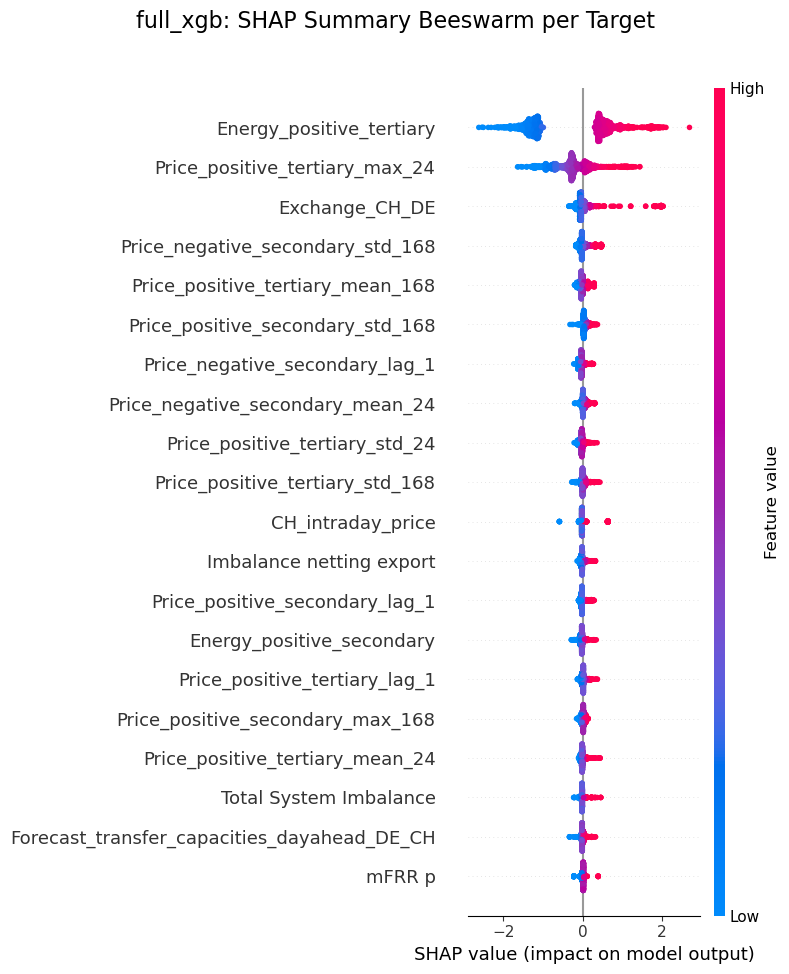

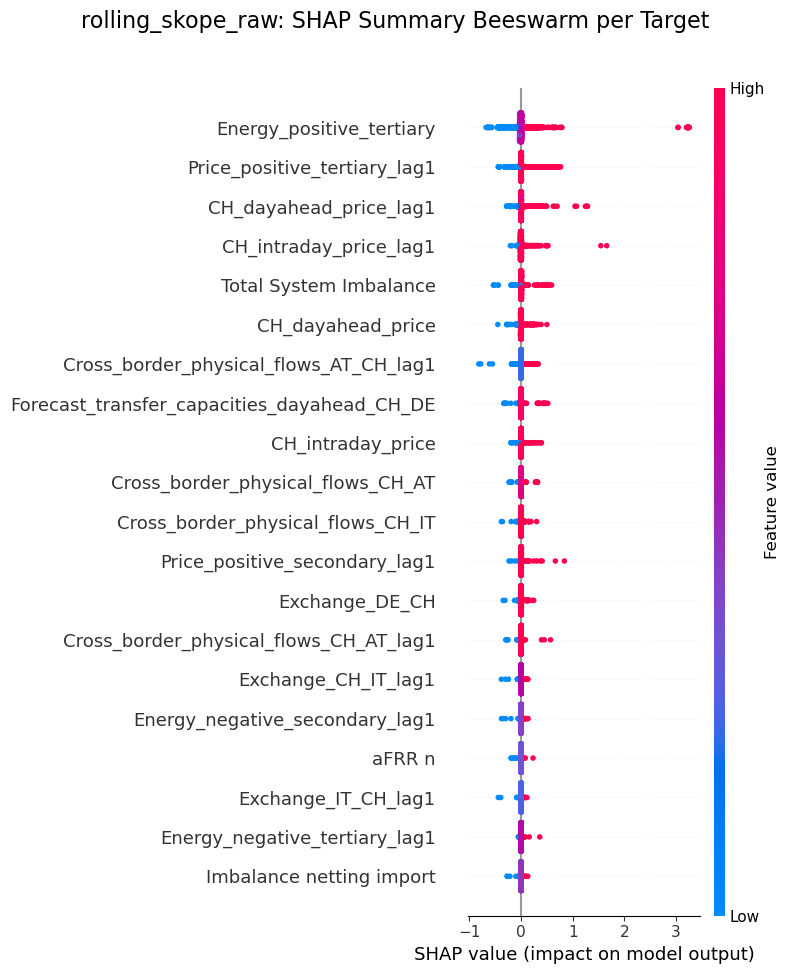

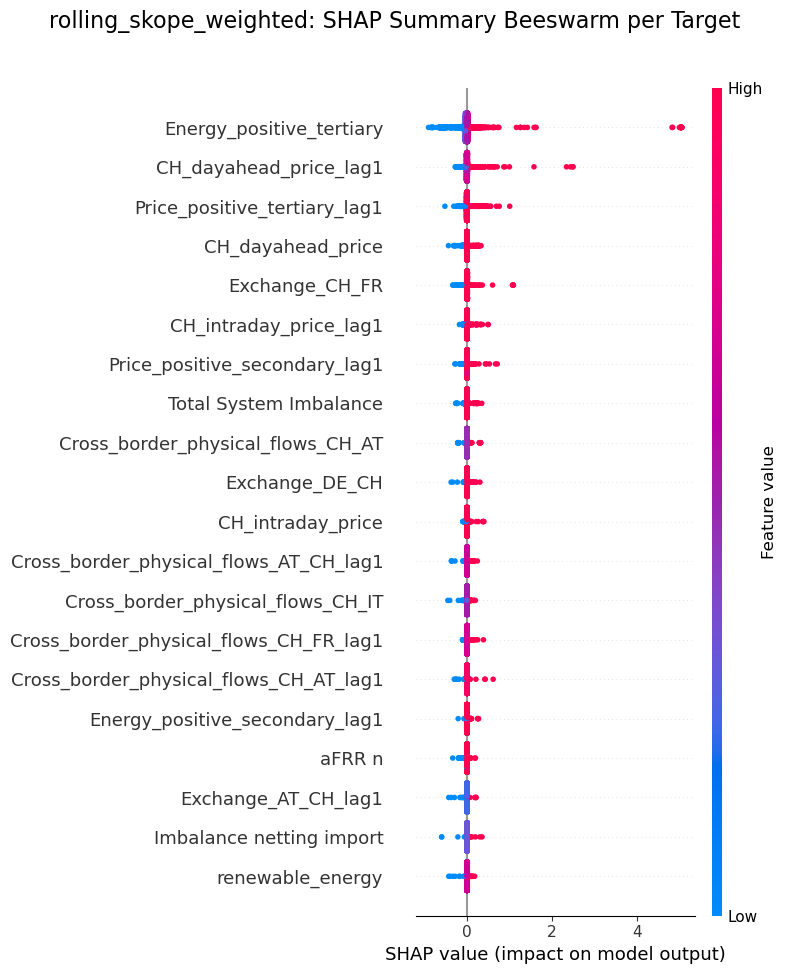

In [24]:
import shap
import matplotlib.pyplot as plt

# Maximum number of features to show in each beeswarm
max_display = 20

for model, targets in shap_by_target.items():
    # Only include those models that have full SHAP matrices
    valid = {t: df for t, df in targets.items() if 'mean_abs_shap' not in df.columns}
    n_valid = len(valid)
    if n_valid == 0:
        continue

    cols = 2
    rows = (n_valid + cols - 1) // cols
    fig = plt.figure(figsize=(cols * 6, rows * 4))

    for idx, (tgt, df) in enumerate(valid.items(), start=1):
        ax = fig.add_subplot(rows, cols, idx)
        # shap.summary_plot will plot into the “current” axes,
        # which is exactly our newly created subplot.
        shap.summary_plot(
            df.values,
            features=df,
            feature_names=df.columns.tolist(),
            plot_type='dot',
            show=False,
            max_display=max_display
        )
        ax.set_title(tgt, pad=10)

    # Remove any unused subplots if total slots > n_valid
    total_slots = rows * cols
    for j in range(n_valid + 1, total_slots + 1):
        fig.delaxes(fig.add_subplot(rows, cols, j))

    fig.suptitle(f"{model}: SHAP Summary Beeswarm per Target", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


In [25]:
# import shap
# import matplotlib.pyplot as plt

# # Number of top features per target to plot
# top_k = 3

# for model, targets in shap_by_target.items():
#     print(f"\n--- SHAP Dependence Plots for model: {model!r} ---")
    
#     for tgt, df in targets.items():
#         # Skip models that only have mean_abs_shap summaries
#         if 'mean_abs_shap' in df.columns:
#             continue
        
#         # Determine top_k features by mean(|SHAP|)
#         mean_abs = df.abs().mean().sort_values(ascending=False)
#         top_features = mean_abs.head(top_k).index.tolist()
#         print(f"Target {tgt!r}: top {top_k} features = {top_features}")
        
#         # Create one figure per target, top_k subplots
#         fig, axes = plt.subplots(1, top_k, figsize=(top_k * 5, 4))
#         if top_k == 1:
#             axes = [axes]
        
#         for ax, feat in zip(axes, top_features):
#             # Plot dependence: feature value vs SHAP value
#             shap.dependence_plot(
#                 feat,
#                 shap_values=df.values,
#                 features=df,
#                 feature_names=df.columns.tolist(),
#                 ax=ax,
#                 show=False
#             )
#             ax.set_title(f"{tgt}\n{feat}")
        
#         plt.tight_layout()
#         plt.show()


In [26]:
# Build df_long once, outside of plotting, to include feature names
records = []
for model_name in rolling_models:
    for tgt, df in shap_by_target[model_name].items():
        if model_name == 'rolling_xgb':
            # aggregated 1-column case
            for feat, val in df['mean_abs_shap'].items():
                records.append({
                    'model': model_name,
                    'target': tgt,
                    'fold': None,
                    'is_empty': False,
                    'abs_shap': val,
                    'feature': feat
                })
        else:
            # raw SHAP matrix with many features
            for key, mat in shap_data[model_name].items():
                if tgt not in key:
                    continue
                fold = key.split("_fold")[-1].split("_")[0]
                is_empty = fold in empty_keys_by_target.get(tgt, set())
                # mat is a DataFrame: columns=features, rows=samples
                for feat in mat.columns:
                    for val in np.abs(mat[feat]):
                        records.append({
                            'model': model_name,
                            'target': tgt,
                            'fold': fold,
                            'is_empty': is_empty,
                            'abs_shap': val,
                            'feature': feat
                        })

df_long = pd.DataFrame(records)


In [27]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # How many points per feature×empty‐flag to display in the swarm
# swarm_sample_size = 200

# for model_name in rolling_models:
#     sub_model = df_long[df_long['model'] == model_name]
#     targets = sorted(sub_model['target'].unique())
#     n_targets = len(targets)
#     fig, axes = plt.subplots(1, n_targets, figsize=(4*n_targets, 5), sharey=True)
#     if n_targets == 1:
#         axes = [axes]

#     fig.suptitle(f"{model_name}: |SHAP| Empty vs Non-Empty by Target", fontsize=16)
#     for ax, tgt in zip(axes, targets):
#         sub = sub_model[sub_model['target'] == tgt]

#         # Draw the box first
#         sns.boxplot(
#             data=sub,
#             x='is_empty',
#             y='abs_shap',
#             order=[False, True],
#             ax=ax,
#             showcaps=True,
#             boxprops={'facecolor':'None'},
#             whiskerprops={'linewidth':1}
#         )

#         # Subsample for the swarm so it stays performant
#         # Group by feature & is_empty, sample up to swarm_sample_size rows
#         sampled = (
#             sub
#             .groupby(['feature','is_empty'], group_keys=False)
#             .apply(lambda df: df.sample(n=min(len(df), swarm_sample_size), random_state=42))
#         )

#         # Overlay a small jittered stripplot (much faster than swarmplot)
#         sns.stripplot(
#             data=sampled,
#             x='is_empty',
#             y='abs_shap',
#             hue='feature',
#             dodge=True,
#             size=3,
#             jitter=0.3,
#             alpha=0.6,
#             ax=ax,
#             palette='tab20',
#             legend=False
#         )

#         ax.set_title(tgt)
#         ax.set_xlabel("")
#         ax.set_xticks([0,1])
#         ax.set_xticklabels(['Non-empty','Empty'], rotation=45)
#         ax.set_ylabel("|SHAP|")

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()


In [28]:
# import pandas as pd
# import numpy as np
# import plotly.express as px

# # 0) Make sure these are defined:
# #   rolling_models = ['rolling_xgb','rolling_skope_raw','rolling_skope_weighted']
# #   shap_data: dict of model → { key: DataFrame }
# #   empty_keys_by_target: dict of target → set of fold strings

# # 1) Build df_long
# records = []
# for model in rolling_models:
#     for tgt in shap_by_target[model].keys():
#         for key, df in shap_data[model].items():
#             if tgt not in key:
#                 continue

#             # extract fold number (if any)
#             parts = key.split("_fold")
#             if len(parts) > 1:
#                 fold = parts[-1].split("_")[0]
#                 is_empty = fold in empty_keys_by_target.get(tgt, set())
#             else:
#                 fold = None
#                 is_empty = False

#             if model == 'rolling_xgb':
#                 # each df here has one column 'mean_abs_shap'
#                 for feat, val in df['mean_abs_shap'].items():
#                     records.append({
#                         'model': model,
#                         'target': tgt,
#                         'fold': fold,
#                         'is_empty': is_empty,
#                         'abs_shap': val,
#                         'feature': feat
#                     })
#             else:
#                 # raw SHAP matrices
#                 mat = shap_data[model][key]
#                 for feat in mat.columns:
#                     for val in np.abs(mat[feat]):
#                         records.append({
#                             'model': model,
#                             'target': tgt,
#                             'fold': fold,
#                             'is_empty': is_empty,
#                             'abs_shap': val,
#                             'feature': feat
#                         })

# df_long = pd.DataFrame(records)

# # 2) Subsample into df_sampled
# sample_n = 200
# parts = []
# group_cols = ['model','target','feature','is_empty']
# for _, grp in df_long.groupby(group_cols, sort=False):
#     parts.append(grp.sample(n=min(len(grp), sample_n), random_state=42))
# df_sampled = pd.concat(parts, ignore_index=True)
# df_sampled['status'] = df_sampled['is_empty'].map({False: 'Non-empty', True: 'Empty'})

# # 3) Interactive violins with ordered facets & legend
# for model in rolling_models:
#     sub = df_sampled[df_sampled['model'] == model]
#     if sub.empty:
#         continue

#     # order targets by mean abs_shap in Non-empty folds
#     target_order = (
#         sub[sub['status']=='Non-empty']
#         .groupby('target')['abs_shap']
#         .mean()
#         .sort_values(ascending=False)
#         .index
#         .tolist()
#     )

#     # order legend by overall mean abs_shap
#     feature_order = (
#         sub
#         .groupby('feature')['abs_shap']
#         .mean()
#         .sort_values(ascending=False)
#         .index
#         .tolist()
#     )

#     fig = px.violin(
#         sub,
#         x='status',
#         y='abs_shap',
#         color='feature',
#         facet_col='target',
#         facet_col_wrap=2,
#         hover_data=['feature','fold','abs_shap'],
#         category_orders={
#             'status': ['Non-empty','Empty'],
#             'target': target_order,
#             'feature': feature_order
#         },
#         labels={'status':'Fold Type','abs_shap':'|SHAP|'},
#         title=f"{model}: |SHAP| Empty vs Non-Empty by Target",
#         points='all'
#     )
#     fig.update_layout(
#         legend_title_text='Feature',
#         height=450,
#         width=900
#     )
#     fig.show()


## Model Comparison

## 8. Temporal Evolution of Feature Importance

In [34]:
import pandas as pd
import numpy as np
import plotly.express as px

# 8. Temporal Evolution of Feature Importance (Non-empty Only)
top_k = 20
rolling_models = ['rolling_xgb','rolling_skope_raw','rolling_skope_weighted']
evo_records = []

for model in rolling_models:
    for key, df in shap_data[model].items():
        if "fold" not in key:
            continue

        # infer target and fold as before
        rest = key.split("__", 1)[1]
        parts = rest.split("_")
        fold_idxs = [i for i,p in enumerate(parts) if p=="fold"]
        if len(fold_idxs) >= 2:
            i1, i2 = fold_idxs[0], fold_idxs[1]
            tgt = "_".join(parts[i1+2:i2])
            fold_num = int(parts[i1+1])
        else:
            i = fold_idxs[0]
            tgt = "_".join(parts[:i])
            fold_num = int(parts[i+1])

        # only keep non-empty folds
        if fold_num not in empty_keys_by_target.get(tgt, set()):
            # compute mean(|SHAP|) per feature
            if "mean_abs_shap" in df.columns:
                imp = df["mean_abs_shap"].abs()
            else:
                imp = df.abs().mean()

            for feat, val in imp.items():
                evo_records.append({
                    "model": model,
                    "target": tgt,
                    "fold": fold_num,
                    "feature": feat,
                    "mean_abs_shap": val
                })

df_evol = pd.DataFrame(evo_records)

for model in rolling_models:
    d = df_evol[df_evol["model"]==model]
    if d.empty:
        continue

    # pick top_k features by overall mean on non-empty folds
    top_feats = (
        d.groupby("feature")["mean_abs_shap"]
         .mean()
         .nlargest(top_k)
         .index
         .tolist()
    )

    dp = d[d["feature"].isin(top_feats)]

    fig = px.line(
        dp,
        x="fold",
        y="mean_abs_shap",
        color="feature",
        facet_col="target",
        facet_col_wrap=2,
        markers=True,
        category_orders={"target": sorted(dp["target"].unique())},
        title=f"{model}: Evolution of Top {top_k} Features (Non-empty Folds Only)",
        labels={"fold":"Fold #","mean_abs_shap":"Mean |SHAP|"}
    )
    fig.update_layout(legend_title_text="Feature", height=500, width=900)
    fig.show()



# 9. Δ-rank of Top 10 Features vs. Stable-Period Project

In [35]:
import pandas as pd
import plotly.express as px

# 9. Δ-rank of Top 10 Features vs. Stable-Period Project

# --- Assumptions: ---
# 1) `stable_importances` is a dict: { target: pd.Series of mean |SHAP| importances from the stable-period project }
#    e.g. stable_importances['Price_negative_secondary'] = pd.Series(index=features, data=importances)
# 2) We're comparing against the “full_xgb” current-period importances:
current_dict = {}
for tgt, df in shap_by_target['full_xgb'].items():
    # compute per-feature importance
    if 'mean_abs_shap' in df.columns:
        imp = df['mean_abs_shap'].abs()
    else:
        imp = df.abs().mean()
    # keep only top 10
    top10 = imp.sort_values(ascending=False).head(10)
    current_dict[tgt] = top10

# 1) Build rank Series for current and stable
current_ranks = {}
stable_ranks = {}
for tgt, cur_imp in current_dict.items():
    # dense ranking: 1 = highest importance
    current_ranks[tgt] = cur_imp.rank(method='dense', ascending=False).astype(int)
    # get stable importances and rank them similarly
    stab_imp = stable_importances.get(tgt)
    if stab_imp is not None:
        # align to same features
        stab_imp_aligned = stab_imp[cur_imp.index].dropna()
        stable_ranks[tgt] = stab_imp_aligned.rank(method='dense', ascending=False).astype(int)

# 2) Compute Δ-rank
delta_records = []
for tgt, cur_rank in current_ranks.items():
    stab_rank = stable_ranks.get(tgt)
    if stab_rank is None:
        continue
    for feat in cur_rank.index:
        delta_records.append({
            'target': tgt,
            'feature': feat,
            'current_rank': cur_rank[feat],
            'stable_rank': stab_rank.get(feat, None),
            'delta_rank': stab_rank.get(feat, None) - cur_rank[feat]
        })

df_delta = pd.DataFrame(delta_records)
# drop any missing stable_rank
df_delta = df_delta.dropna(subset=['stable_rank'])

# 3) Plot Δ-rank as horizontal bars, faceted by target
fig = px.bar(
    df_delta,
    x='delta_rank',
    y='feature',
    orientation='h',
    facet_col='target',
    facet_col_wrap=2,
    color='delta_rank',
    labels={'delta_rank':'Δ Rank (Stable – Current)', 'feature':'Feature'},
    title='Δ Rank of Top-10 Features: Current vs. Stable Period'
)
fig.update_layout(showlegend=False, height=500, width=900)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))  # clean facet titles
fig.show()


NameError: name 'stable_importances' is not defined